In [248]:
# resetting the entire session
%reset -f  
# Iris data-set
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((120, 4), (120,))

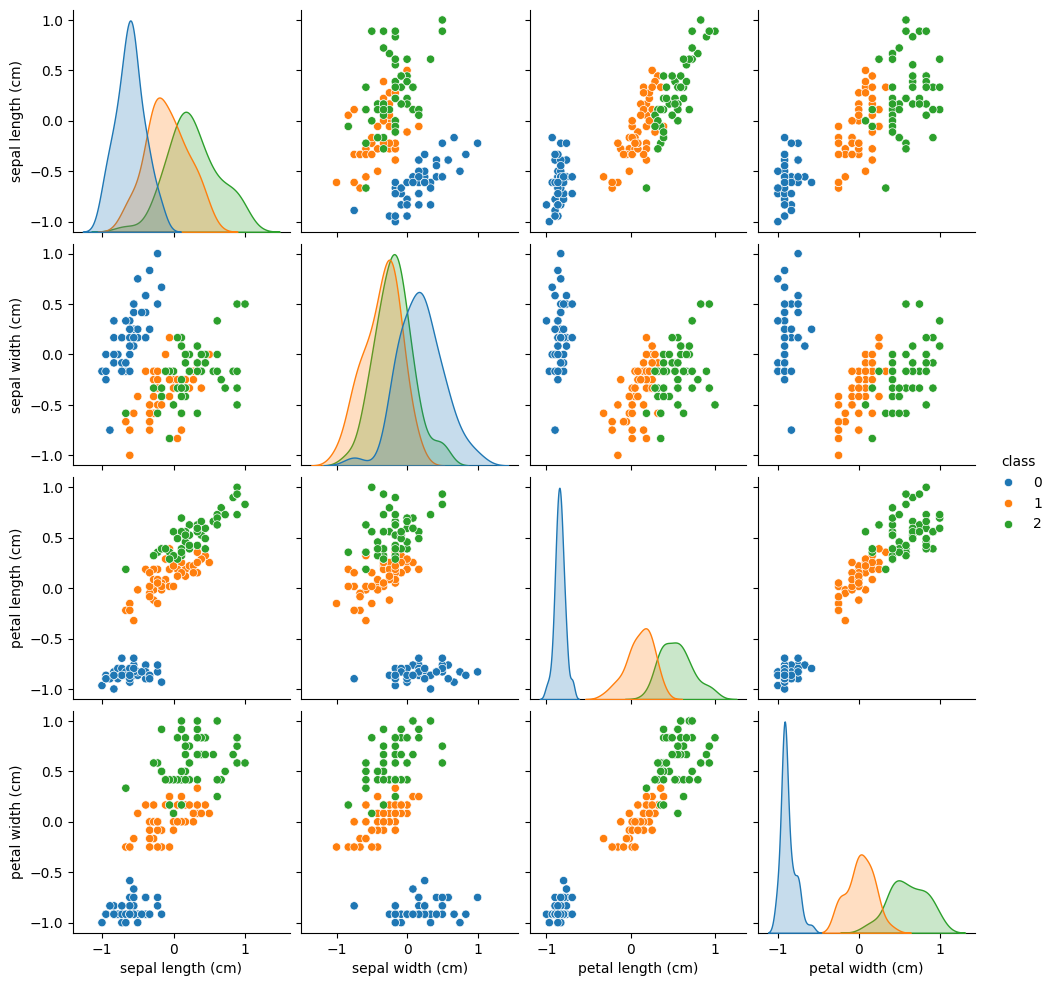

In [250]:
#from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns

df = pd.DataFrame(X, columns=iris.feature_names)
df["class"] = pd.Series(y)
sns.pairplot(df, hue="class", palette="tab10")

### Quantum Machine Learning Model
we’ll train a variational quantum classifier (VQC), available in Qiskit Machine Learning 
 Two of its central elements are the feature map and ansatz.

In [251]:
# features circuit
from qiskit.circuit.library import ZZFeatureMap
num_features = X.shape[1]
feature_circ = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_circ.decompose().draw(output='text', fold=-1)

┌───┐┌─────────────┐                                                                                                                                                                                                                            
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■────────────────────────────────────■─────────■─────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │                                    │         │                                         │                                                                                      
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼────────────────────────────────────┼────■────┼────────────────────────────────────■────┼────■────────────────────────────────────■────────────────────────────────────────────
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐┌──────────────────────────────┐┌─┴─┐┌─┴─┐  │  ┌──────────────────────────────┐┌─┴─┐  │    │                                    │                                            
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├──┼──┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──┼────┼────────────────────────────────────┼────■────────────────────────────────────■──
     ├───┤├─────────────┤                                          └───┘└──────────────────────────────┘└───┘└───┘┌─┴─┐├──────────────────────────────┤└───┘┌─┴─┐┌─┴─┐┌──────────────────────────────┐┌─┴─┐┌─┴─┐┌──────────────────────────────┐┌─┴─┐
q_3: ┤ H ├┤ P(2.0*x[3]) ├─────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[3])) ├─────┤ X ├┤ X ├┤ P(2.0*(π - x[1])*(π - x[3])) ├┤ X ├┤ X ├┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├
     └───┘└─────────────┘                                                                                         └───┘└──────────────────────────────┘     └───┘└───┘└──────────────────────────────┘└───┘└───┘└──────────────────────────────┘└───┘

In [252]:
# Anzatz circuit
# This circuit has 16 parameters named θ[0], ..., θ[15]. These are the trainable weights of the classifier.
from qiskit.circuit.library import TwoLocal,EfficientSU2
nReps=1
#ansatz_circ =TwoLocal(num_qubits=num_features, reps=nReps, rotation_blocks='ry', entanglement_blocks='cz', entanglement='circular')
ansatz_circ=EfficientSU2(num_qubits=num_features, reps=nReps, entanglement='linear')
ansatz_circ.decompose().draw(output='text', fold=-1)

┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐                          
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├──■──┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├──────────────────────────
     ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤┌───────────┐             
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├┤ X ├─────■───────┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├─────────────
     ├──────────┤├──────────┤└───┘   ┌─┴─┐     └──────────┘├───────────┤┌───────────┐
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├────────┤ X ├──────────■──────┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├
     ├──────────┤├──────────┤        └───┘        ┌─┴─┐    ├───────────┤├───────────┤
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─────────────────────┤ X ├────┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├
     └──────────┘└──────────┘                     └───┘    └───────────┘└───────────┘

In [253]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("cross-entropy value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid(True)
    plt.show()

### Training of VQC= variational quantum classifier 

In [254]:
# tools for minimizer
# To make the training process faster, we choose a gradient-free optimizer.
from qiskit.algorithms.optimizers import COBYLA
nIter=150
optimizer = COBYLA(maxiter=nIter)

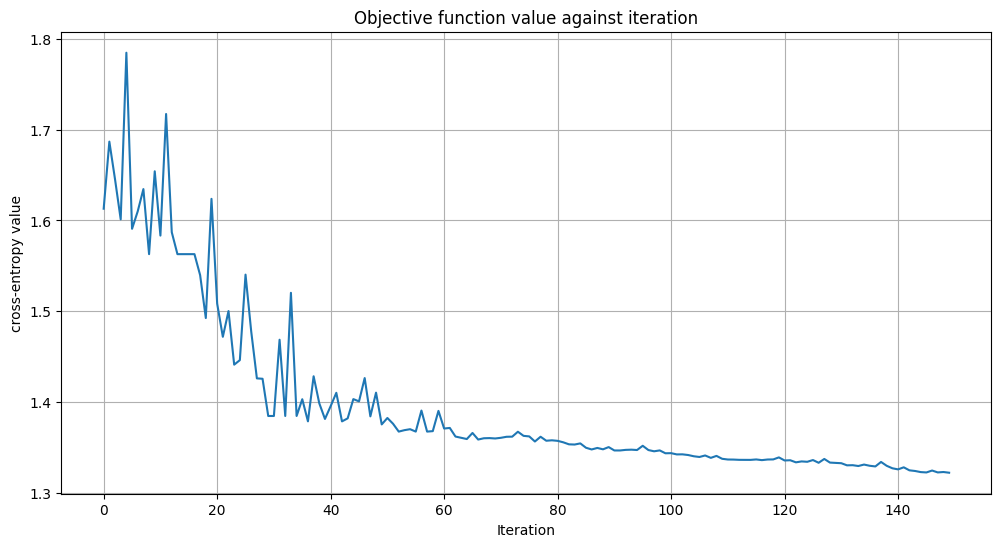

Training time: 101 seconds, last value:1.32


In [255]:
# Training may take some time. Please, be patient.
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler  # state vector
sampler = Sampler()

vqc = VQC(
    sampler=sampler,
    feature_map=feature_circ,
    ansatz=ansatz_circ,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
# Fit the VQC on the training data
result=vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds, last value:%.2f"%objective_func_vals[-1])

### predict for few samples

In [256]:
# Predict labels for the test data
y_pred = vqc.predict(X_test)

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[4 2 4]
 [3 5 1]
 [0 5 6]]


In [257]:
# Now we check out how well our classical model performs. 
# mean accuracy of the classifier
train_score_c4 = vqc.score(X_train, y_train)
test_score_c4 = vqc.score(X_test, y_test)

print(f"mean accuracy  on the training dataset: {train_score_c4:.2f}")
print(f"mean accuracy on the test dataset:     {test_score_c4:.2f}")

mean accuracy  on the training dataset: 0.65
mean accuracy on the test dataset:     0.50


In [258]:
weights=vqc.weights
weights.shape, weights

((16,),
 array([ 1.32587416,  1.10113573,  0.76210424, -0.88127991,  1.05802386,
         1.11282364,  1.91010341,  0.68606981,  0.16798348,  0.8260182 ,
        -0.61850424,  1.25920352,  0.55849005,  1.15506065,  1.02983002,
         0.98041571]))

In [259]:
nSamp=20
samples=X_test[:nSamp]
labels=y_test[:nSamp]
pred=vqc.predict(samples)
nok=0
for p,t in zip(pred,labels):
    print(p,t,p==t)
    nok+=p==t
print('avr prob=%.2f'%(nok/nSamp))

1 1 True
0 0 True
2 2 True
1 1 True
2 1 False
0 0 True
0 1 False
2 2 True
1 1 True
0 1 False
1 2 False
1 0 False
1 0 False
2 0 False
0 0 True
0 1 False
1 2 False
1 1 True
1 1 True
2 2 True
avr prob=0.55


In [260]:
print(vqc.circuit)

     ┌────────────────────────────────────┐»
q_0: ┤0                                   ├»
     │                                    │»
q_1: ┤1                                   ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                   ├»
     │                                    │»
q_3: ┤3                                   ├»
     └────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                     ├
«     │                                                                                                      │
«q_1: ┤1                                                                                                     ├
«     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15]) │
«q_2: ┤2                                

In [261]:
vqc.loss

In [262]:
vqc.num_classes

3

### Restart training  from the last solution

In [263]:
vqc.save("vqc_classifier.model")

In [269]:
vqc2 = VQC.load("vqc_classifier.model")
vqc2.warm_start = True
vqc2.neural_network.sampler = sampler
vqc2.optimizer = COBYLA(maxiter=nIter)

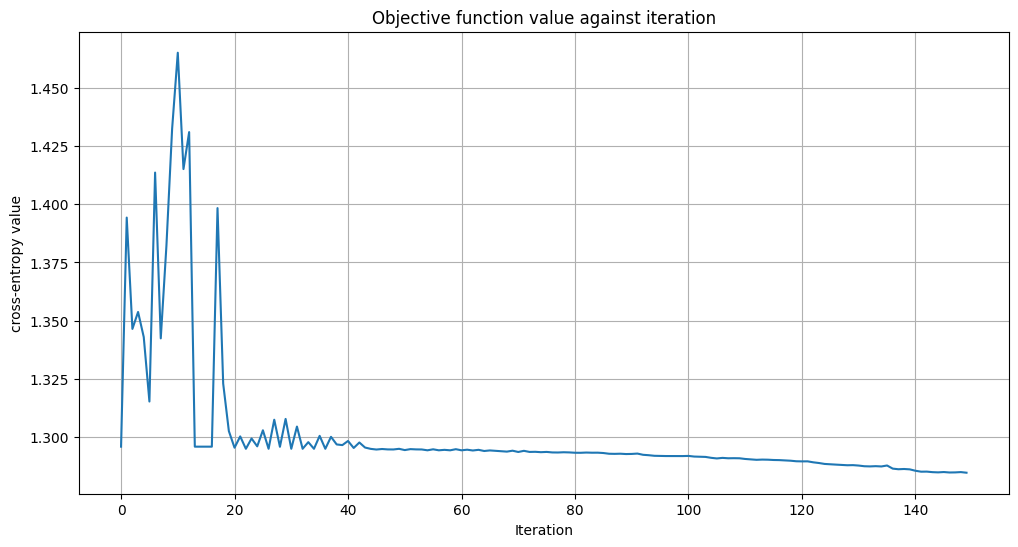

Training time: 102 seconds, last value:1.28


In [270]:
# clear objective value history
objective_func_vals = []

start = time.time()
# Fit the VQC on the training data
vqc2.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds, last value:%.2f"%objective_func_vals[-1])

In [266]:
# Predict labels for the test data
y_pred = vqc2.predict(X_test)

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred) 
print(conf_matrix)

[[7 1 2]
 [2 6 1]
 [1 3 7]]


In [268]:
vqc2.save("vqc_classifier.model")